In [57]:
#%matplotlib widget

import numpy as np
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
import yaml
from IPython.display import display  # to display variables in a "nice" way

try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

pd.options.display.max_rows = 140
pd.options.display.max_columns = 200

In [58]:
rs = 296312+302736
df_path = "responses_hw.csv" 
df = pd.read_csv(df_path)
# display(df)

## Exercise 1: Loading and Preparing the Data

In [59]:
df = df.iloc[:,:-10]
X = df.values[:,:-10]
X

array([[5.0, 3.0, 2.0, ..., 3.0, 2.0, 3.0],
       [4.0, 4.0, 2.0, ..., 4.0, 5.0, 3.0],
       [5.0, 5.0, 2.0, ..., 3.0, 4.0, 5.0],
       ...,
       [4.0, 3.0, 1.0, ..., 3.0, 5.0, 1.0],
       [5.0, 3.0, 3.0, ..., 1.0, 5.0, 3.0],
       [5.0, 5.0, 4.0, ..., 1.0, 2.0, 2.0]], dtype=object)

In [60]:
col_entertainment = list(df.columns)[0:63]
col_personality = list(df.columns)[63:140]
np.random.seed(rs)
remove_entertainment = np.random.choice(col_entertainment,5)
remove_personality = np.random.choice(col_personality,10)
print(remove_entertainment)
print(remove_personality)

['Country' 'Geography' 'Latino' 'Slow songs or fast songs' 'Chemistry']
['Personality' 'Loneliness' 'Reliability' 'New environment' 'Fake'
 'Heights' 'Internet usage' 'Prioritising workload' 'Interests or hobbies'
 'Mood swings']


## Exercise 2: Preprocessing

In [61]:
data = {'Smoking': {'never smoked': 1, 'tried smoking':2, 'former smoker':3, 'current smoker':4},
        'Alcohol': {'never':1, 'social drinker': 2, 'drink a lot':3},
        'Punctuality': {'early':1, 'on time':2, 'late':3},
        'Lying': {'never':1, 'only to avoid hurting someone': 2, 'sometimes':3 ,'everytime it suits me':4},
        'Internet usage': {'no time at all':1, 'less than an hour a day':2, 'few hours a day':3, 'most of the day':4}      
       }
df = df.replace(data)
df_1 = df.iloc[:,0:63]
df_2 = df.iloc[:, 63:]

In [62]:
workdf_1 = df_1.drop(columns=remove_entertainment)
workdf_2 = df_2.drop(columns=remove_personality)
workdf_tot = pd.concat((workdf_1, workdf_2), axis = 1)

In [63]:
workdf_tot_na = workdf_tot.dropna()
workdf_1_na = workdf_1.dropna()
X_tot_na = workdf_tot_na.values
X_1_na = workdf_1_na.values

In [64]:
workdf_tot_0 = workdf_tot.fillna(value = 0)
workdf_1_0 = workdf_1.fillna(value = 0)
X_tot_0 = workdf_tot_0.values
X_1_0 = workdf_1_0.values

In [65]:
workdf_1_med = workdf_1.fillna(value = workdf_1.median(axis=0))
workdf_tot_med = workdf_tot.fillna(value = workdf_tot.median(axis=0))
X_tot_med = workdf_tot_med.values
X_1_med = workdf_1_med.values

# Exercise 3: Computation of the PCs

In [66]:
dict_df1 = {"Data with deleted rows" : X_1_na , "Data with 0 instead of NaN": X_1_0, "Data with median instead of NaN": X_1_med}

In [67]:
# aggiungere roba al print
dict_pca_1 = {}
dict_y_1 = {}
for k, v in dict_df1.items():
    pca = PCA(n_components = 0.3)
    pca.fit(v)
    m = min(pca.n_components_, 5)
    print('Il minimo è', m)
    dict_pca_1[k] = (PCA(n_components = m))
    dict_pca_1[k].fit(v)
    dict_y_1[k] = dict_pca_1[k].transform(v)
    
dict_pca_1

Il minimo è 4
Il minimo è 4
Il minimo è 4


{'Data with deleted rows': PCA(n_components=4),
 'Data with 0 instead of NaN': PCA(n_components=4),
 'Data with median instead of NaN': PCA(n_components=4)}

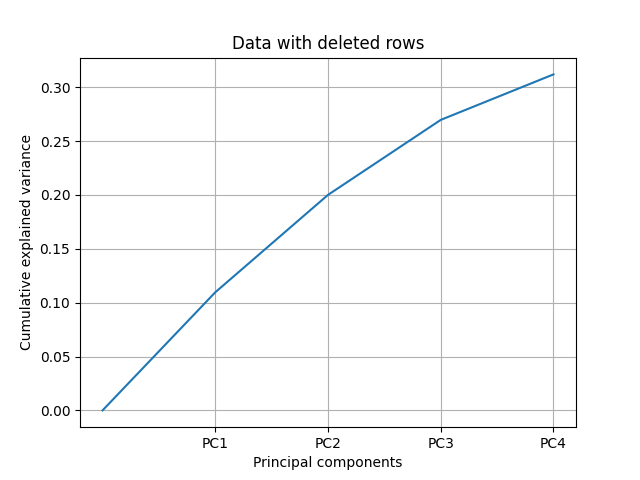

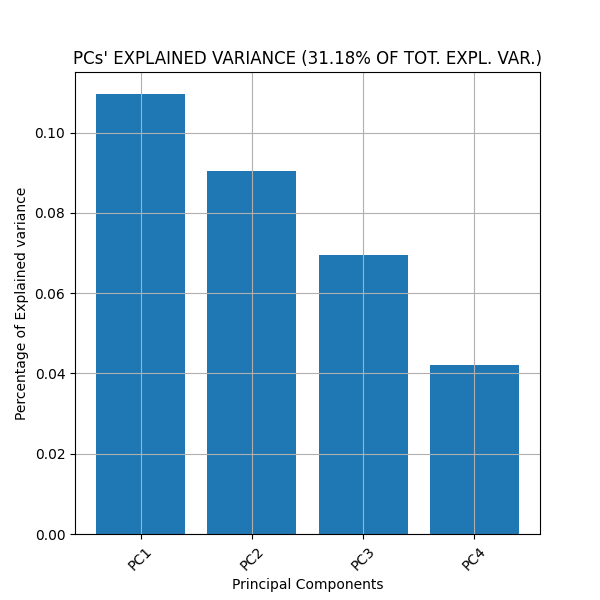

C:\Users\virgi\AppData\Local\Temp/ipykernel_27984/1551569327.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


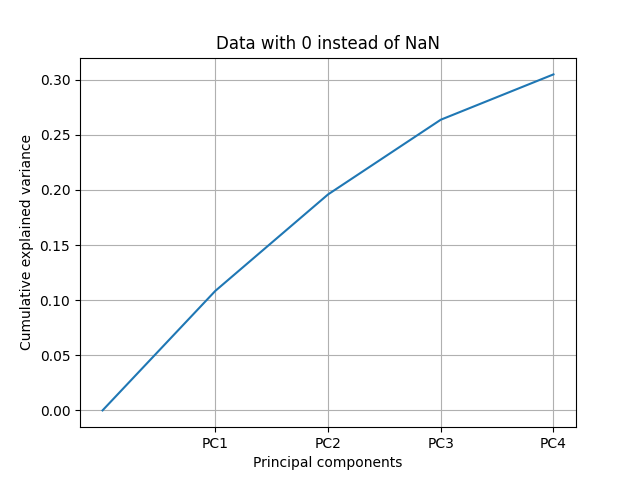

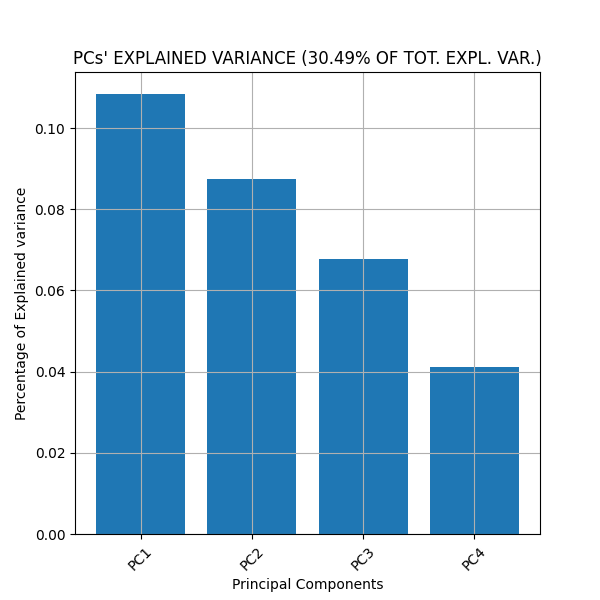

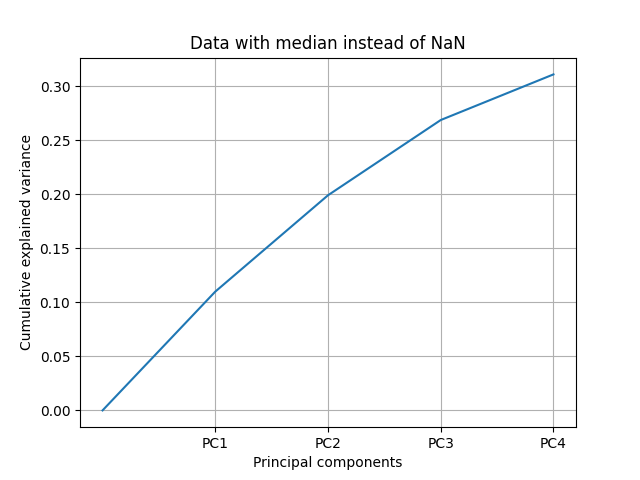

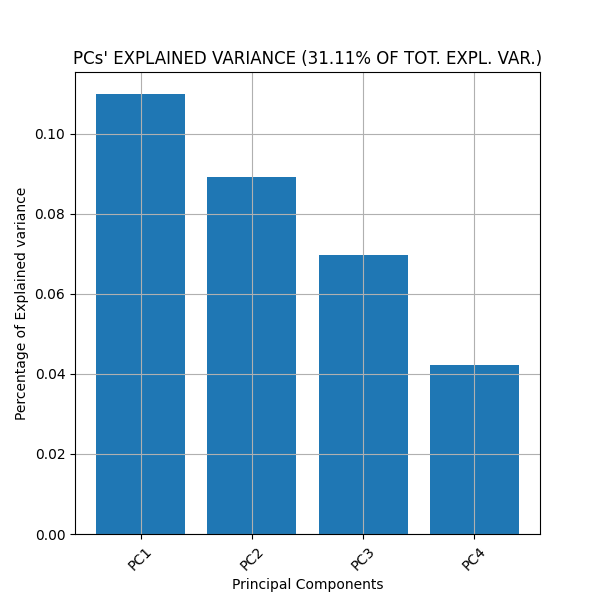

In [68]:
for k,v in dict_pca_1.items():
    m = v.n_components
    # Curve of cumulative percentage of explained variance
    plt.figure()
    plt.plot(np.insert(np.cumsum(v.explained_variance_ratio_), 0, 0))
    plt.title(k)
    plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)])
    plt.xlabel('Principal components')
    plt.ylabel('Cumulative explained variance')
    plt.grid()
    plt.show()
    
    round_expl_var_ratio = np.round(v.explained_variance_ratio_.sum() * 100, decimals=2)

    # Barplot of percentage of explained variance
    plt.figure(figsize=(6, 6))
    plt.bar(range(1, m + 1), v.explained_variance_ratio_)
    plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
    plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)],
               rotation=45)
    plt.xlabel('Principal Components')
    plt.ylabel('Percentage of Explained variance')
    plt.grid()
    plt.show()

# Exercise 4: Interpretation of the PCs

In [69]:
cat_colors={} 
 
# Colors initialization for Music Preferences 
for el in list(workdf_1.columns)[:16]: 
    cat_colors[el]= 'tab:blue' 
     
# Colors initialization for Movie Preferences 
for el in list(workdf_1.columns)[16:28]: 
    cat_colors[el]= 'tab:orange' 
 
# Colors initialization for Hobbies & Interests 
for el in list(workdf_1.columns)[28:]: 
    cat_colors[el]= 'tab:green' 
     
list_colors = [] 
for k,v in cat_colors.items(): 
    list_colors.append(cat_colors[k])

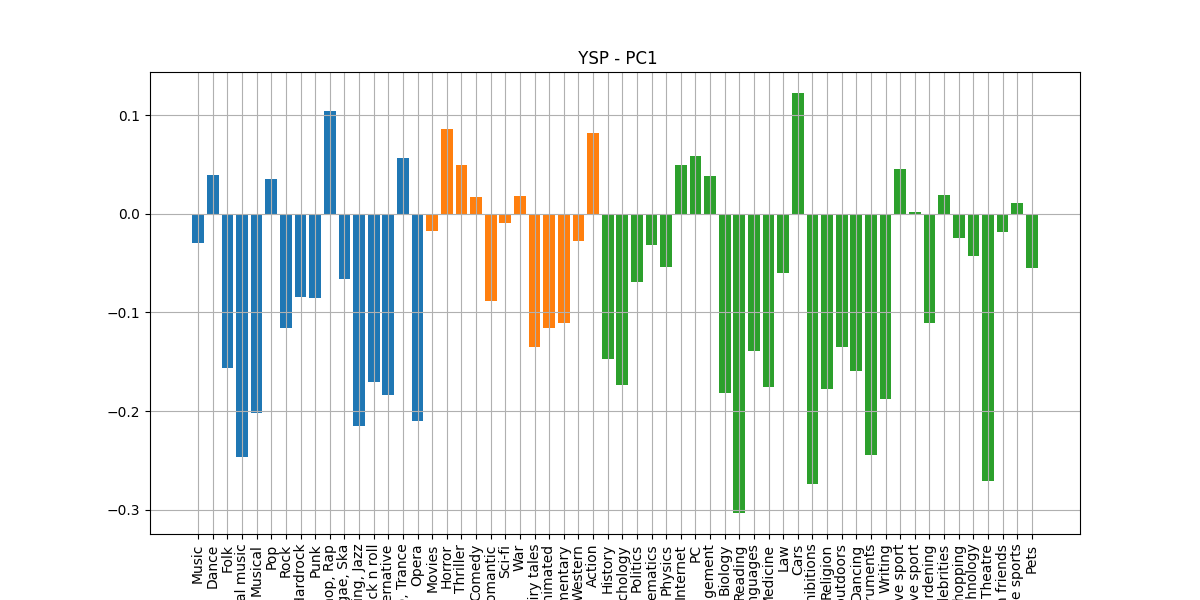

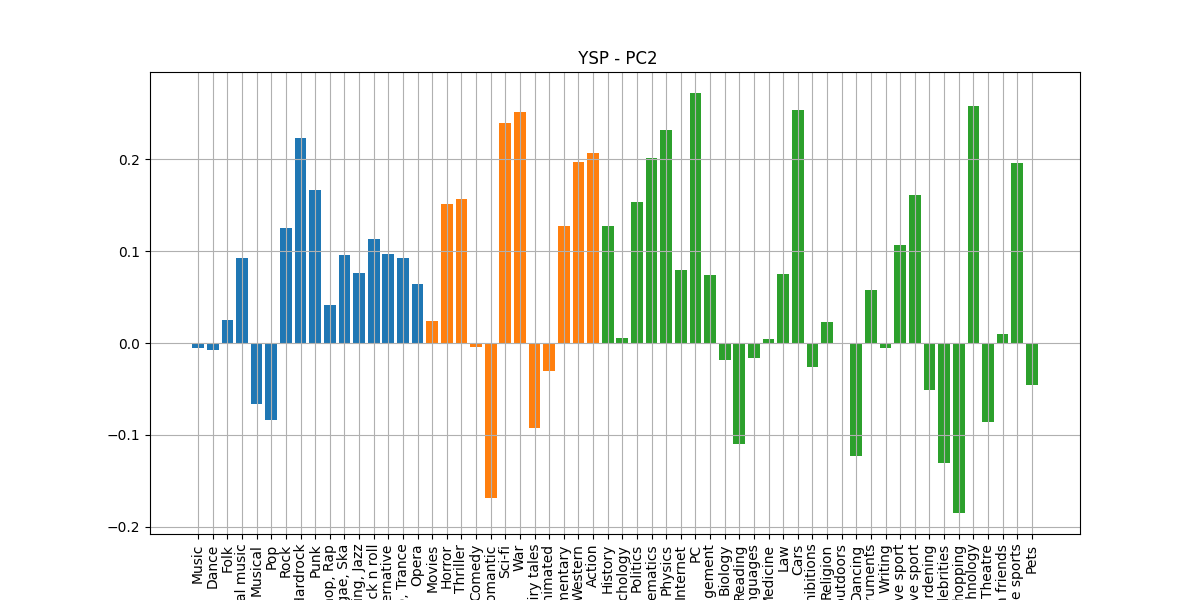

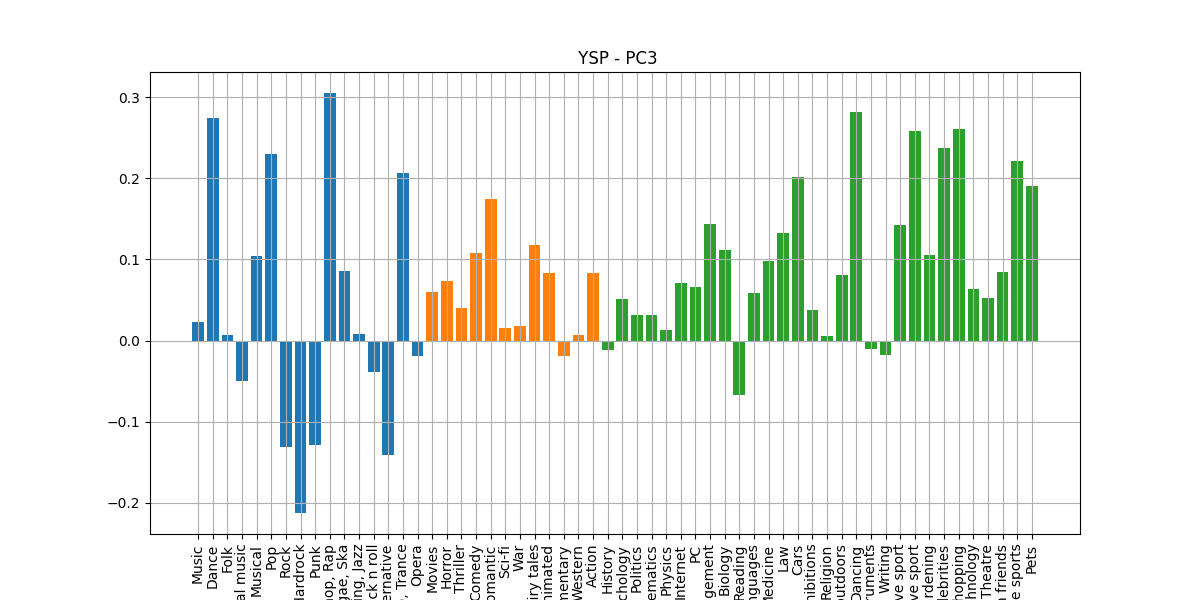

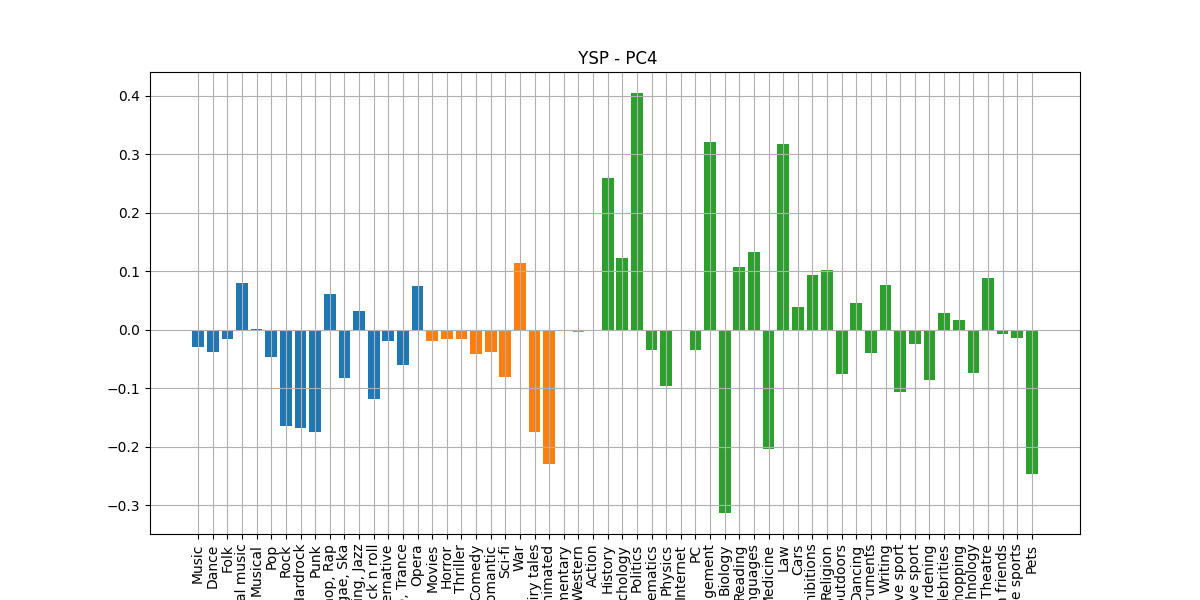

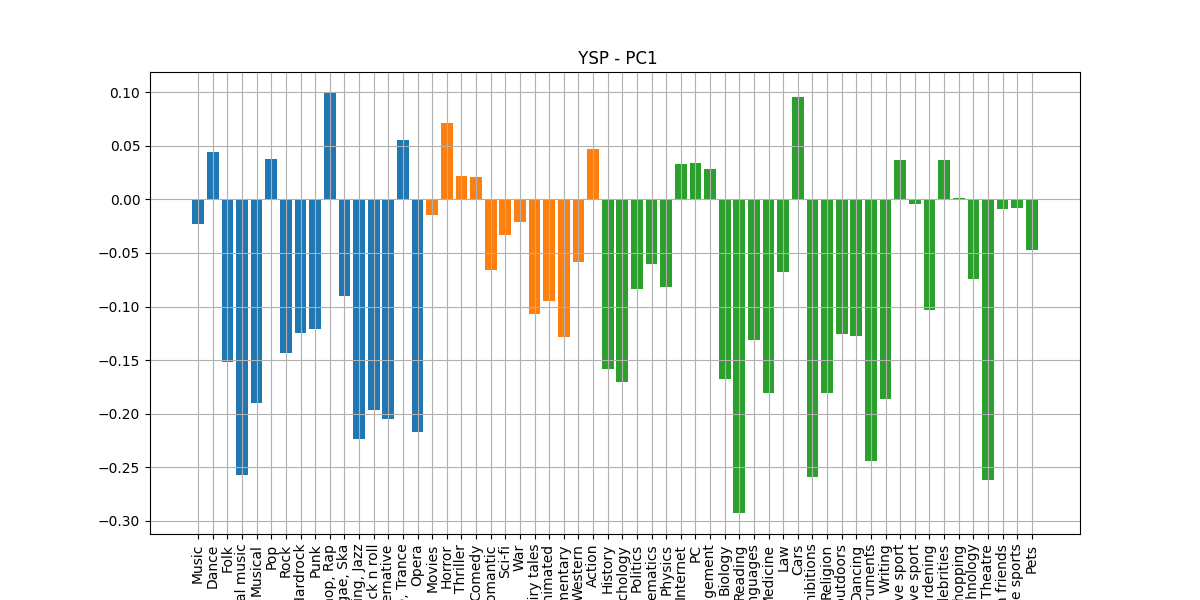

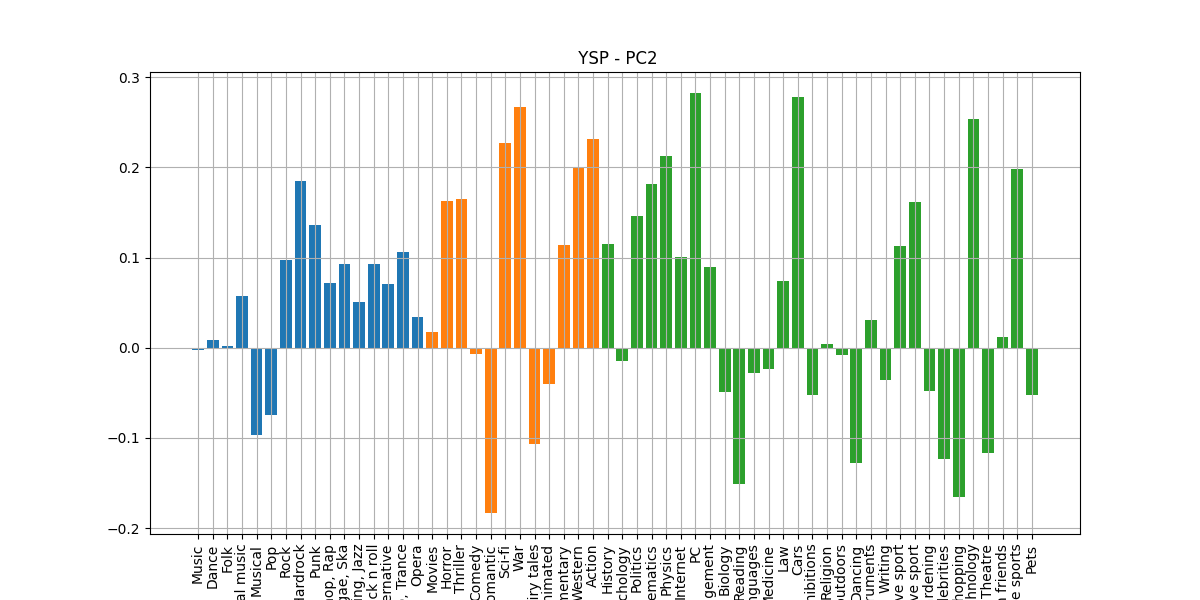

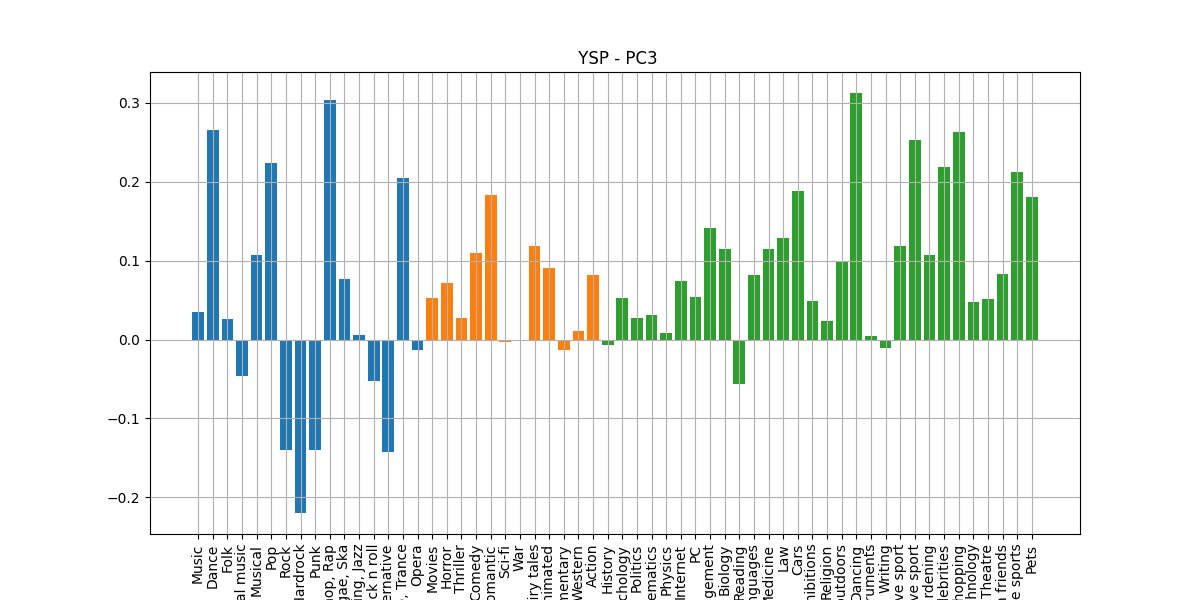

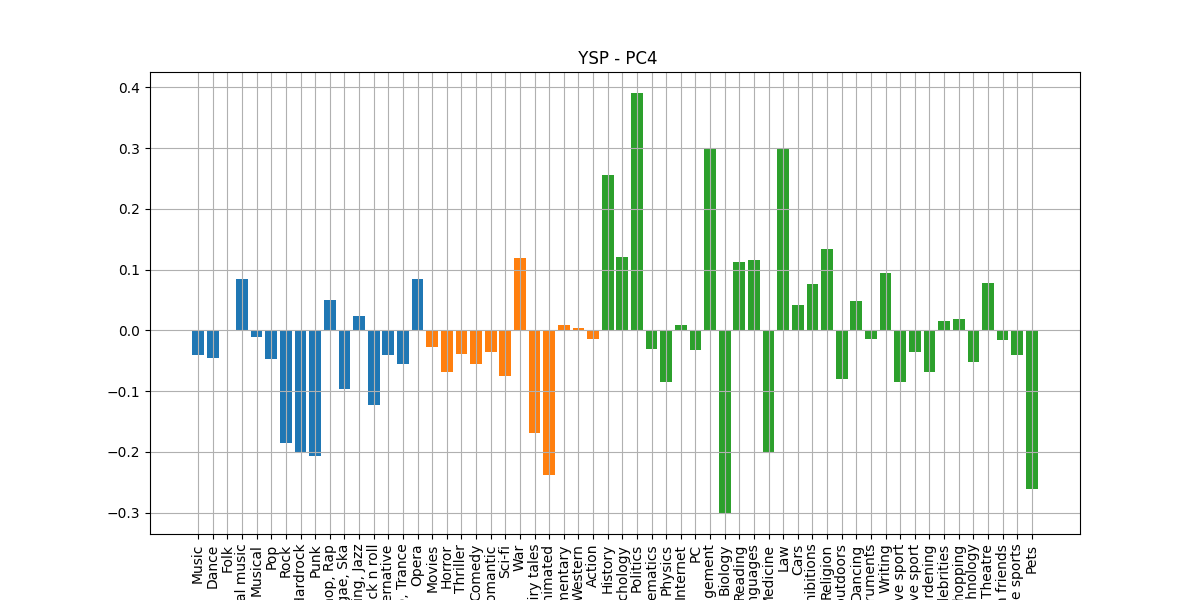

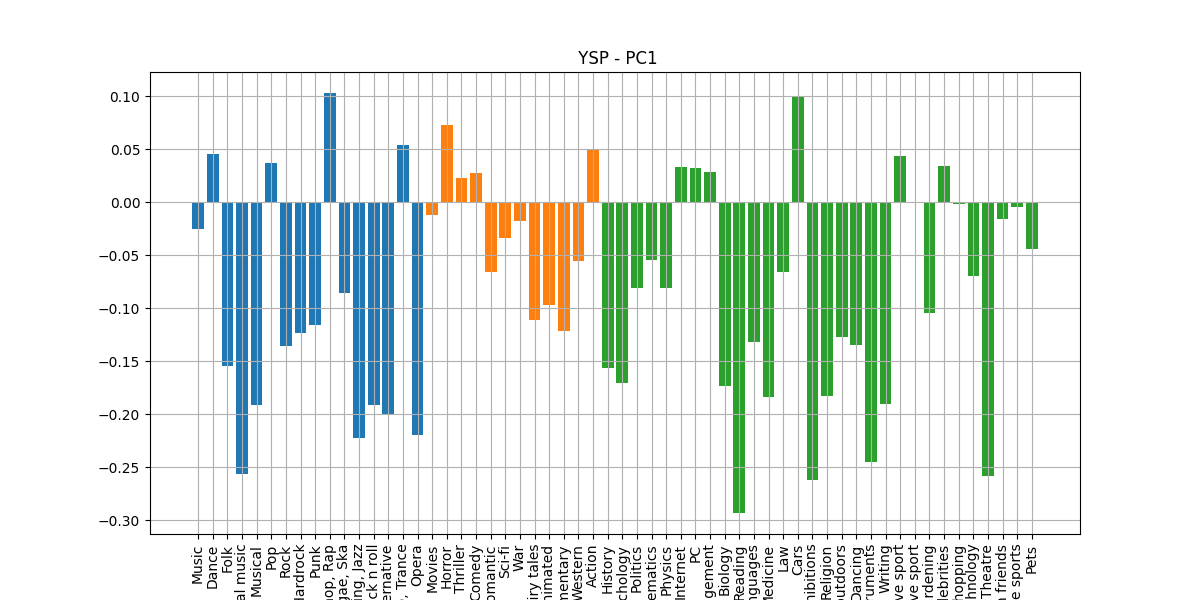

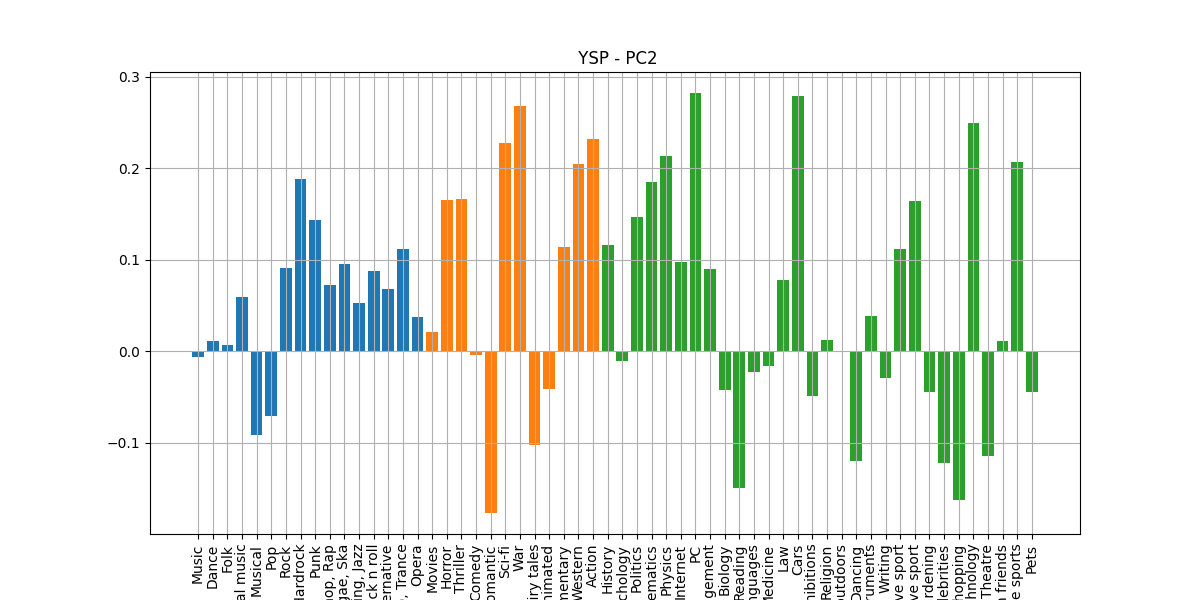

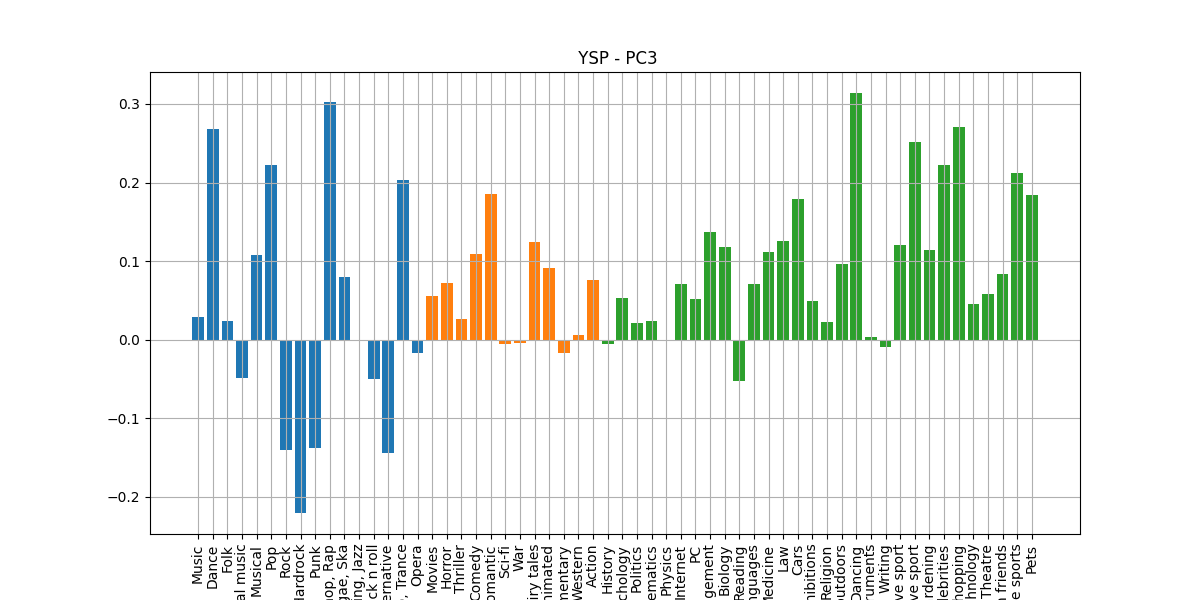

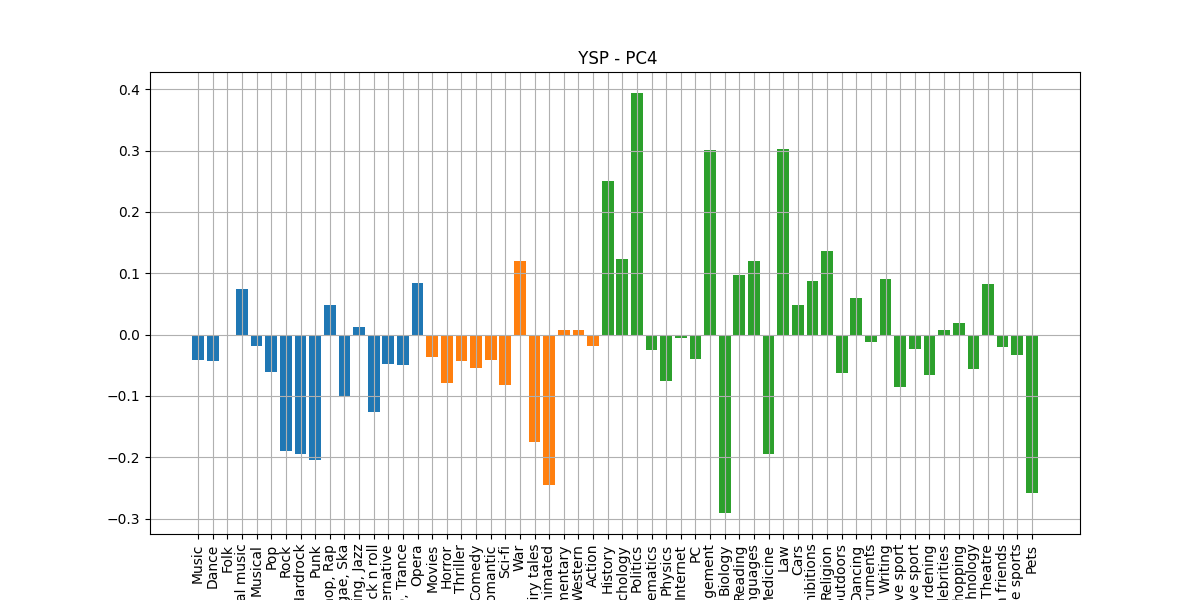

In [72]:
for k, v in dict_pca_1.items():
    for i in range(v.n_components_):
        plt.figure(figsize = (12, 6))
        plt.bar(np.arange(v.n_features_), v.components_[i, :], color = list_colors)
        plt.xticks(ticks = np.arange(v.n_features_), 
                   labels = workdf_1.columns.to_list(),
                   rotation = 90)
        plt.title(f' YSP - PC{i+1}')
        plt.grid()
        plt.show()


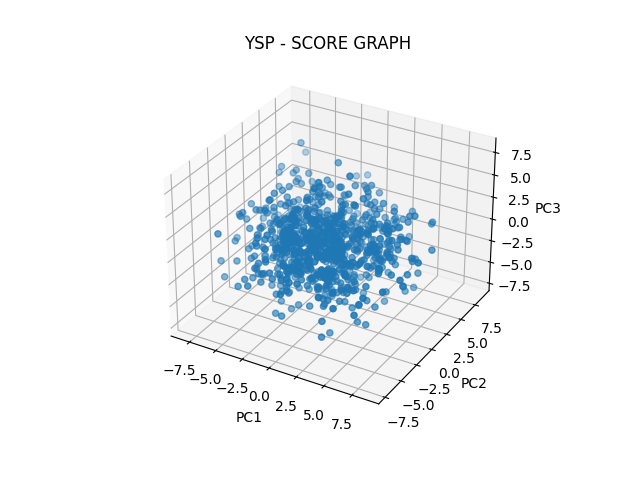

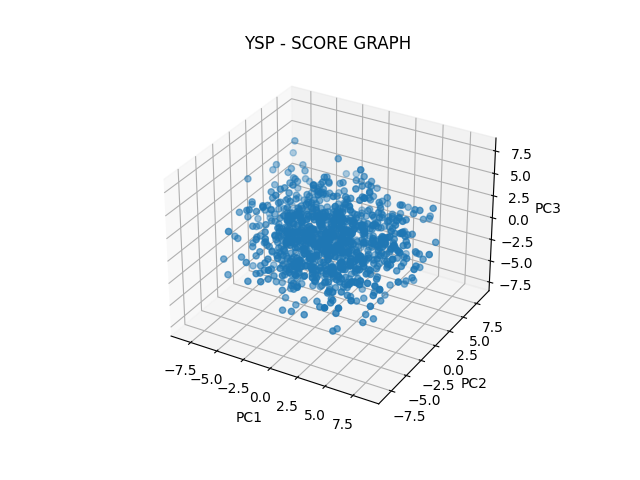

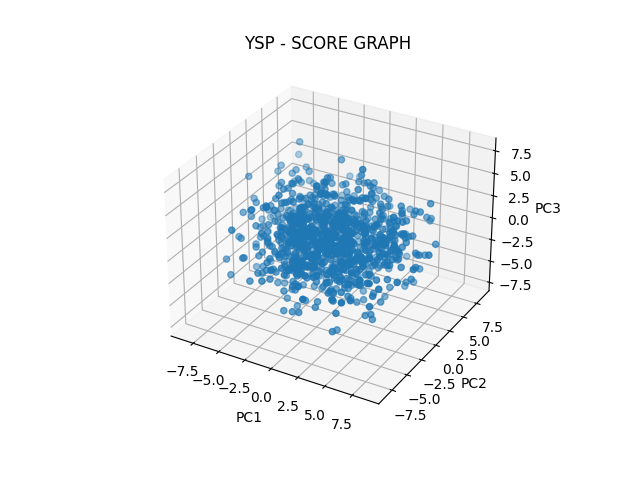

In [73]:
#Score Graph
for k, v in dict_y_1.items():
    fig_winescore = plt.figure()
    ax = fig_winescore.add_subplot(111, projection='3d')
    ax.scatter(v[:, 0], v[:, 1], v[:, 2])
    plt.title('YSP - SCORE GRAPH')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.grid()
    plt.show()

# Exercise 5: k-Means

In [92]:
# giocare con i parametri in modo furbo

import sklearn.model_selection

# Definizione delle liste di valori tra i quali "scorrere" per gli iper-parametri:
nclust_list = list(range(3, 11)
iter_list = [300, 500, 1000]
n_init_list = [3,10]
init_list = ['k-means++', 'random']

hparameters = {'n_clusters':nclust_list,'init': 'max_iter':iter_list, 'n_init':n_init_list} #dizionario
km = KMeans()

score = silhouette_score(, km.labels_)
km_gs = GridSearchCV(estimator=km, 
                      param_grid=hparameters, 
                      scoring='f1_weighted')

In [91]:
# INITIALIZE SOME LISTS TO STORE THE TEMPORARY RESULTS AND, THEN, MAKE COMPARISONS

# START THE FOR-CYCLE TO RUN THE k-MEANS AND MEASURING THE SILHOUETTE COEFFICIENT
for y in lista_y_1:
    km_list = []
    silcoeff_list = []
    k_list = list(range(3, 11))

    for i in range(len(k_list)):
        print(f'****************** START k-MEANS WITH k={k_list[i]} ******************')
        print('Computing...')
        km_list.append(KMeans(n_clusters=k_list[i], n_init=3, random_state=rs))
        km = km_list[i]
        km.fit(y)
        silcoeff_list.append(silhouette_score(y, km.labels_))
        print(f'****************** END k-MEANS WITH k={k_list[i]} ******************')
        print('')

    # FIND THE BEST VALUE OF k AND THE BEST KMeans OBJECT
    i_best = np.argmax(silcoeff_list)
    k = k_list[i_best]
    km = km_list[i_best]

    # VISUALIZE THE RESULT
    print('')
    print('')
    print('****************** RESULTS OF THE SEARCH... ******************')
    print(f'BEST SILHOUETTE SCORE: {np.max(silcoeff_list)} --> k = {k}')
    print('**************************************************************')

****************** START k-MEANS WITH k=3 ******************
Computing...
****************** END k-MEANS WITH k=3 ******************

****************** START k-MEANS WITH k=4 ******************
Computing...
****************** END k-MEANS WITH k=4 ******************

****************** START k-MEANS WITH k=5 ******************
Computing...
****************** END k-MEANS WITH k=5 ******************

****************** START k-MEANS WITH k=6 ******************
Computing...
****************** END k-MEANS WITH k=6 ******************

****************** START k-MEANS WITH k=7 ******************
Computing...
****************** END k-MEANS WITH k=7 ******************

****************** START k-MEANS WITH k=8 ******************
Computing...
****************** END k-MEANS WITH k=8 ******************

****************** START k-MEANS WITH k=9 ******************
Computing...
****************** END k-MEANS WITH k=9 ******************

****************** START k-MEANS WITH k=10 ******************


# Exercise 8

In [68]:
lista_tot = [X_tot_na, X_tot_0, X_tot_med]

In [69]:
pca = PCA(n_components = 0.3)
for elemento in lista_tot:
    pca.fit(elemento)
    m = min(pca.n_components_, 6)
    print('Il minimo è', m)

Il minimo è 6
Il minimo è 6
Il minimo è 6


In [70]:
pca_tot_na = PCA(n_components = 6)
pca_tot_0 = PCA(n_components = 6)
pca_tot_med = PCA(n_components = 6)

pca_tot_na.fit(X_tot_na)
pca_tot_0.fit(X_tot_0)
pca_tot_med.fit(X_tot_med)

lista_pca_tot = [pca_tot_na, pca_tot_0, pca_tot_med]

In [72]:
for el_pca in lista_pca_tot:
    # Curve of cumulative percentage of explained variance
    plt.figure()
    plt.plot(np.insert(np.cumsum(el_pca.explained_variance_ratio_), 0, 0))
    plt.title('Workdf_tot')
    plt.xticks(ticks=np.arange(1, el_pca.n_components + 1), 
               labels=[f'PC{i}' for i in range(1, el_pca.n_components + 1)])
    plt.xlabel('Principal components')
    plt.ylabel('Cumulative explained variance')
    plt.grid()
    plt.show()
    
    
    round_expl_var_ratio = np.round(el_pca.explained_variance_ratio_.sum() * 100, decimals=2)

    # Barplot of percentage of explained variance
    plt.figure(figsize=(6, 6))
    plt.bar(range(1, m + 1), el_pca.explained_variance_ratio_)
    plt.title(f"PCs' EXPLAINED VARIANCE ({round_expl_var_ratio}% OF TOT. EXPL. VAR.)")
    plt.xticks(ticks=np.arange(1, m + 1), 
               labels=[f'PC{i}' for i in range(1, m + 1)],
               rotation=45)
    plt.xlabel('Principal Components')
    plt.ylabel('Percentage of Explained variance')
    plt.grid()
    plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-72-528f5810ed4b>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …